In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Inspection of Measurement  
inspector = inspect(engine)

column = inspector.get_columns('measurement')

for c in column:
    print(c["name"], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Inspection of Station  
inspector = inspect(engine)

column = inspector.get_columns('station')

for c in column:
    print(c["name"], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

latest_date = recent_date[0]

print(f"The most recent date is {latest_date}")

The most recent date is 2017-08-23


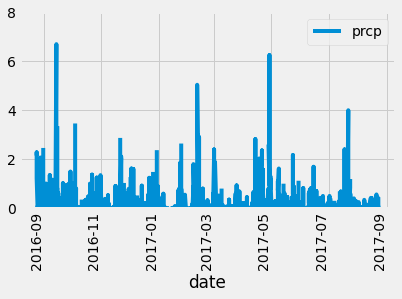

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.

latest_date = datetime.strptime(latest_date, '%Y-%m-%d')
one_year_ago = latest_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores

ttm = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

df_ttm = pd.DataFrame(ttm)
df_ttm["date"] = pd.to_datetime(df_ttm["date"])
df_ttm.set_index("date", inplace = True)

# Sort the dataframe by date

df_ttm = df_ttm.sort_values(by = 'date', ascending = True)

# Use Pandas Plotting with Matplotlib to plot the data
df_ttm.plot(y = 'prcp', rot = 90, ylim = [0,8])
plt.show()


In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
df_ttm.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number stations in the dataset
total_number_station = session.query(func.count(Station.station)).all()

print(f"The total amount of stations is: {total_number_station[0][0]}")

The total amount of stations is: 9


In [16]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

most_active = session.query(Measurement.station, func.count(Measurement.station)).\
        group_by(Measurement.station).\
        order_by(func.count(Measurement.station).desc()).all()

most_active

# Isolate Most Active Station

most_active_station = most_active[0][0]

print(most_active_station)

USC00519281


In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

most_active_stat = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
        group_by(Measurement.station).\
        filter(Measurement.station == most_active_station).all()

df_active = pd.DataFrame(most_active_stat, columns = ["Min tobs", "Max tobs", "Avg. tobs"])
df_active              

,Min tobs,Max tobs,Avg. tobs
0,54.0,85.0,71.663781


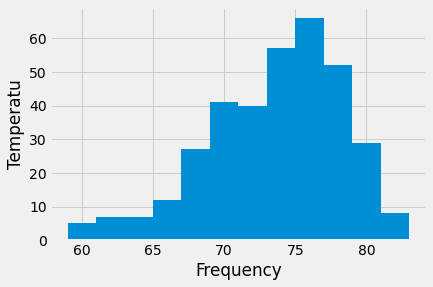

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

ttm_active = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date >= one_year_ago).\
            filter(Measurement.station == most_active_station).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

ttm_active = pd.DataFrame(ttm_active)

# Use Pandas Plotting with Matplotlib to plot the data
plt.hist(ttm_active['tobs'],  bins = 12)
plt.xlabel("Frequency")
plt.ylabel("Temperatu")
plt.show()

# Close session

In [19]:
# Close Session
session.close()